In [1]:
import sys
sys.path.append(r"../src")

import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from decay_tools.cross_section import (
    plot_energy_groups,
    calculate_group_summary,
    sum_integral_and_ion_count,
    calculate_cross_sections,
    plot_cross_section_vs_energy,
    calculate_cross_section_uncertainty,
    plot_cross_section_with_errors,
    plot_cross_section_with_energy_errors,
    build_cross_section_table,
    build_group_summary,
    plot_shifted_cross_section,
    plot_single_channel,
    plot_combined_cross_section
)

In [2]:
df = pd.read_csv("./SECH.csv")
df.columns = df.columns.str.strip()
df.head()

,File,Median Energy,Total Integral,Total Correlations (ms),Total Correlations (mks),Total
0,sorted_6mg8u01,134.2,14890,NaN,NaN,0
1,sorted_6mg8u02,133.3,22540,NaN,NaN,0
2,sorted_6mg8u03,133.9,347240,NaN,NaN,0
3,sorted_6mg8u04,133.5,350020,NaN,NaN,0
4,sorted_6mg8u05,133.2,48920,NaN,NaN,0


In [3]:
selected_columns = ["File", "Median Energy", "Total Integral", "Total"]
df_selected = df[selected_columns]
df_selected.head()

,File,Median Energy,Total Integral,Total
0,sorted_6mg8u01,134.2,14890,0
1,sorted_6mg8u02,133.3,22540,0
2,sorted_6mg8u03,133.9,347240,0
3,sorted_6mg8u04,133.5,350020,0
4,sorted_6mg8u05,133.2,48920,0


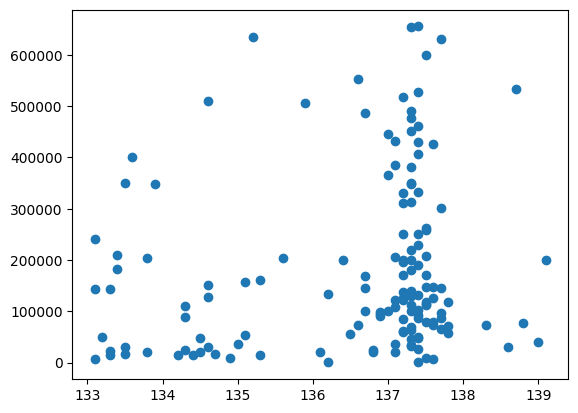

In [4]:
plt.scatter(df["Median Energy"], df["Total Integral"]);

In [5]:
### Clusterize data

N_CLUSTERS = 5
df.columns = df.columns.str.strip()

energies = df["Median Energy"].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
labels = kmeans.fit_predict(energies)

df_clean = df[df["Median Energy"].notna()].copy()
df_clean["GroupLabel"] = labels
df_clean["Energy"] = df_clean["Median Energy"]

cluster_centers = kmeans.cluster_centers_.flatten()
sorted_centers = sorted(cluster_centers)

boundaries = []
for i in range(len(sorted_centers) - 1):
    midpoint = (sorted_centers[i] + sorted_centers[i+1]) / 2
    boundaries.append(midpoint)

min_energy = df_clean["Energy"].min()
max_energy = df_clean["Energy"].max()
boundaries = [min_energy - 1e-6] + boundaries + [max_energy + 1e-6]

def assign_group(energy):
    for i in range(N_CLUSTERS):
        if boundaries[i] < energy <= boundaries[i+1]:
            return i
    return -1

df_clean["EnergyGroup"] = df_clean["Energy"].apply(assign_group)

for i in range(N_CLUSTERS):
    group = df_clean[df_clean["EnergyGroup"] == i]
    if group.empty:
        continue
    group_min = round(group["Energy"].min(), 2)
    group_max = round(group["Energy"].max(), 2)
    group_center = round(group["Energy"].mean(), 2)

    print(f"\n=== Group {i+1} ===")
    print(f"Mean energy: {group_center} MeV")
    print(f"Energy range: from {group_min} to {group_max} МэВ")


=== Group 1 ===
Mean energy: 133.43 MeV
Energy range: from 133.1 to 133.9 МэВ

=== Group 2 ===
Mean energy: 134.76 MeV
Energy range: from 134.2 to 135.6 МэВ

=== Group 3 ===
Mean energy: 136.63 MeV
Energy range: from 135.9 to 137.0 МэВ

=== Group 4 ===
Mean energy: 137.38 MeV
Energy range: from 137.1 to 137.8 МэВ

=== Group 5 ===
Mean energy: 138.75 MeV
Energy range: from 138.3 to 139.1 МэВ


In [6]:
# validate that there is no missing data
df_clean["EnergyGroup"].value_counts(dropna=False)

EnergyGroup
3    83
1    20
2    20
0    16
4     6
Name: count, dtype: int64

In [7]:
df_clean.columns

Index(['File', 'Median Energy', 'Total Integral', 'Total Correlations (ms)',
       'Total Correlations (mks)', 'Total', 'GroupLabel', 'Energy',
       'EnergyGroup'],
      dtype='object')

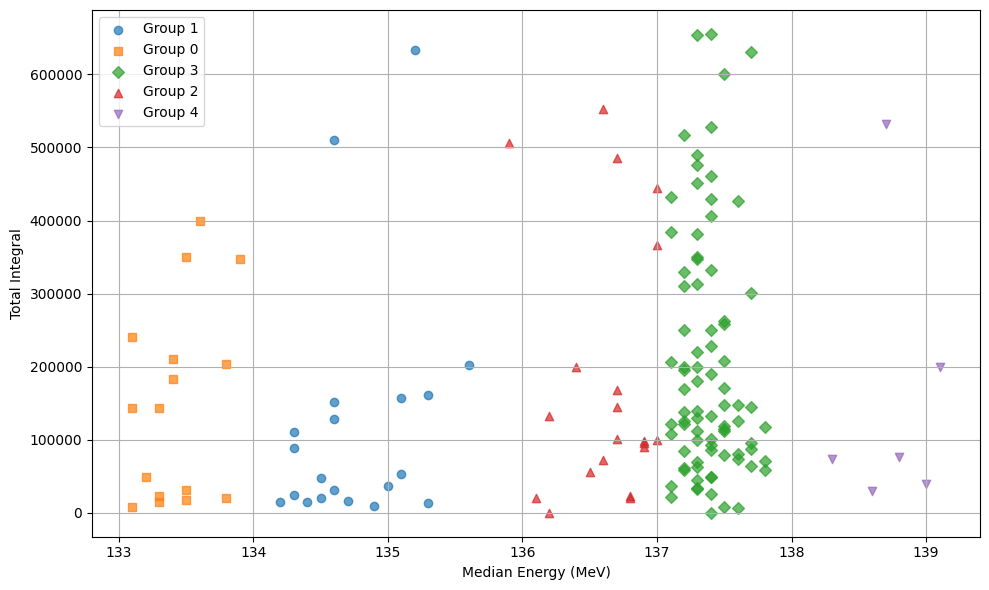

In [8]:
plot_energy_groups(
    df=df_clean,
    energy_group_col="EnergyGroup",
    energy_col="Median Energy",
    integral_col="Total Integral"
)

In [9]:
summary_df = calculate_group_summary(
    df=df_clean,
    energy_group_col="EnergyGroup",
    energy_col="Median Energy",
    integral_col="Total Integral",
    n_events_col="Total"
)
summary_df

,Group,Total integral,Wheighted median energy,Events number
0,1,2428040,134.908,6
1,2,2385420,133.500,3
2,3,17206890,137.370,52
3,4,3680370,136.623,10
4,5,952860,138.770,2


In [14]:
ion_df = sum_integral_and_ion_count(ion_charge=10, n_groups=5)

,Группа,Суммарный интеграл (мкКл),Количество ионов
0,1,2385420,1.49e+18
1,2,2428040,1.52e+18
2,3,3680370,2.30e+18
3,4,17206890,1.07e+19
4,5,952860,5.95e+17


In [15]:
sigma_df = calculate_cross_sections(df_clean, n_groups=5)

,Группа,Событий N,Ионов i,Сечение (см²),Сечение (пб)
0,1,3,1.49e+18,1.388e-34,138.76
1,2,6,1.52e+18,2.726e-34,272.64
2,3,10,2.30e+18,2.998e-34,299.78
3,4,52,1.07e+19,3.334e-34,333.42
4,5,2,5.95e+17,2.316e-34,231.58


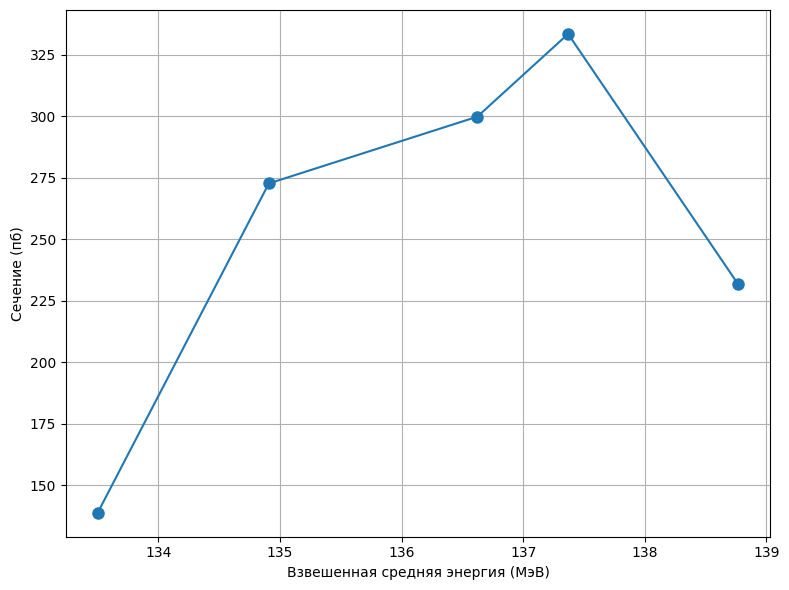

In [16]:
plot_cross_section_vs_energy(sigma_df, summary_df)

In [17]:
sigma_df = calculate_cross_section_uncertainty(sigma_df)

,Группа,Сечение (пб),Погрешность вверх (пб),Погрешность вниз (пб)
0,1,138.76,126.37,80.11
1,2,272.64,156.74,111.30
2,3,299.78,124.78,94.80
3,4,333.42,52.65,46.24
4,5,231.58,279.54,163.75


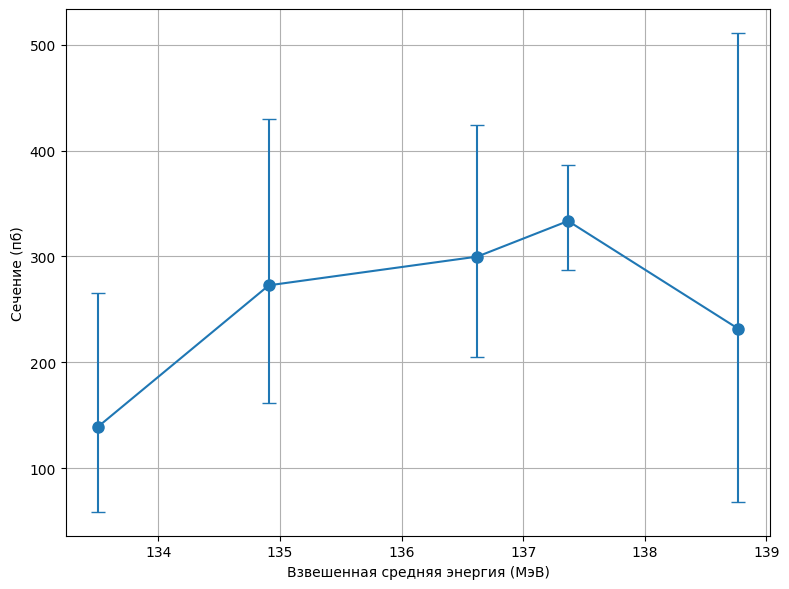

In [18]:
plot_cross_section_with_errors(summary_df=summary_df, sigma_df=sigma_df)

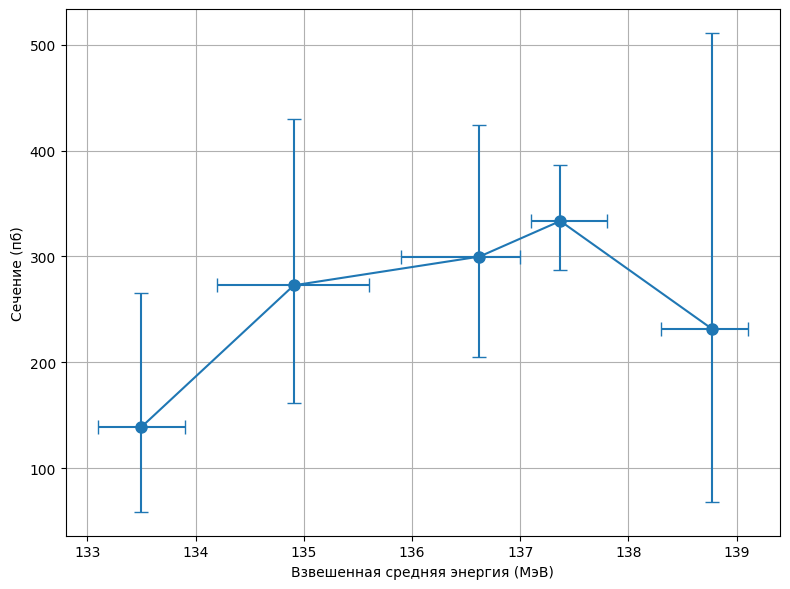

In [20]:
plot_cross_section_with_energy_errors(df_clean, summary_df, sigma_df, n_groups=5)

In [22]:
final_table = build_cross_section_table(df_clean, summary_df, sigma_df, n_groups=5)

,Точка,Энергия (МэВ),Ошибка энергии +,Ошибка энергии –,Сечение (пб),Ошибка сечения +,Ошибка сечения –
0,1,133.500,0.400,0.400,138.76,126.37,80.11
1,2,134.908,0.692,0.708,272.64,156.74,111.30
2,3,136.623,0.377,0.723,299.78,124.78,94.80
3,4,137.370,0.430,0.270,333.42,52.65,46.24
4,5,138.770,0.330,0.470,231.58,279.54,163.75


In [23]:
group_summary_df = build_group_summary(df_clean, summary_df, n_groups=5)

,Группа,Центральная энергия (средняя),Взвешенная энергия,Диапазон (Мин–Макс),Ошибка + (от макс),Ошибка – (от мин)
0,1,133.425,133.500,133.1 – 133.9,0.400,0.400
1,2,134.755,134.908,134.2 – 135.6,0.692,0.708
2,3,136.630,136.623,135.9 – 137.0,0.377,0.723
3,4,137.383,137.370,137.1 – 137.8,0.430,0.270
4,5,138.750,138.770,138.3 – 139.1,0.330,0.470


Смещение энергии (подложка + мишень/2): 4.440 МэВ


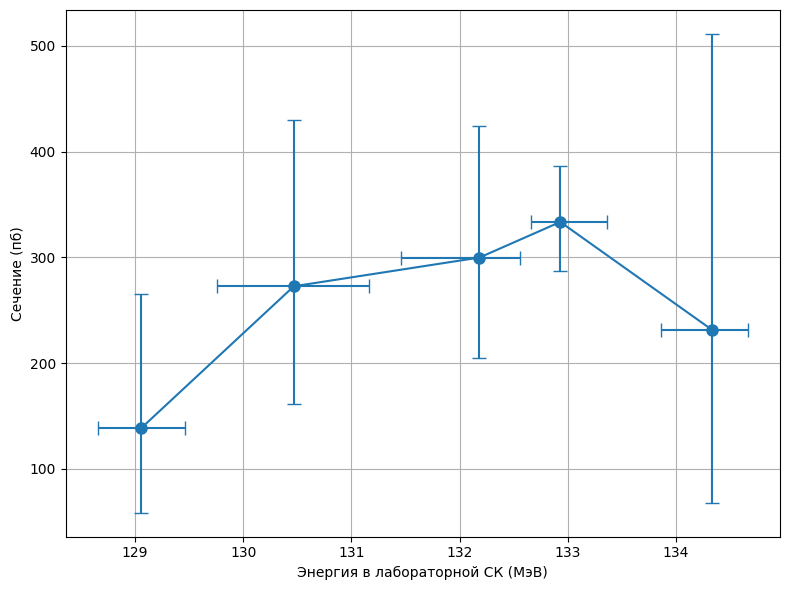

In [26]:
x_lab, y, xerr_lower, xerr_upper, yerr_lower, yerr_upper = plot_shifted_cross_section(
    df_clean, summary_df, sigma_df, n_groups=5
)

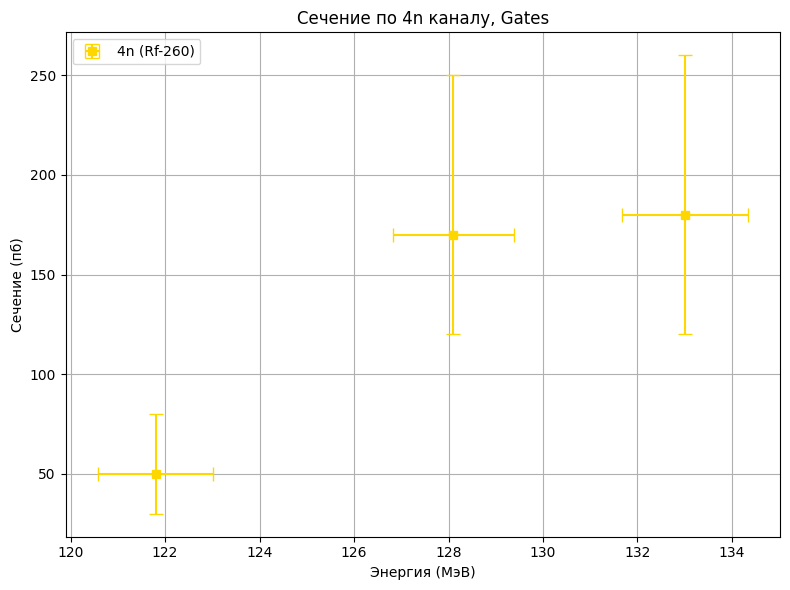

In [28]:
data_4n = [
    (1.2180E+08, 5.0000E-11, 3.0000E-11, 2.0000E-11, 1.2180E+06, 1.2180E+06),
    (1.2810E+08, 1.7000E-10, 8.0000E-11, 5.0000E-11, 1.2810E+06, 1.2810E+06),
    (1.3300E+08, 1.8000E-10, 8.0000E-11, 6.0000E-11, 1.3300E+06, 1.3300E+06)
]

plot_single_channel(data_4n, label="4n (Rf-260)", color="gold", marker='s', title="Сечение по 4n каналу, Gates")


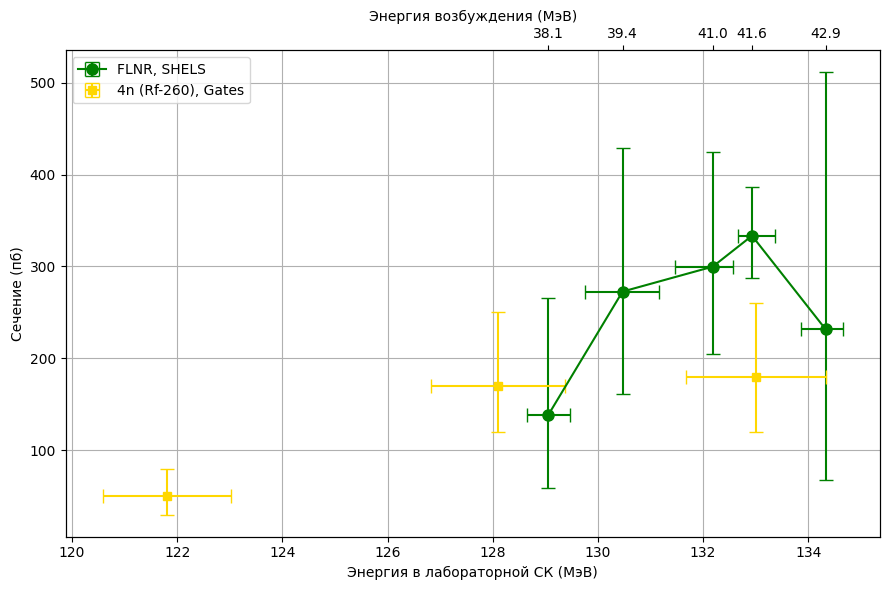

In [30]:
plot_combined_cross_section(x_lab, y, xerr_lower, xerr_upper, yerr_lower, yerr_upper)